#### Universidade Federal de MInas Gerais - UFMG
#### Programa de Pós Graduação em Engenharia Elétrica - PPGEE
#### Técnicas de Modelagem e Controle de Conversores Estáticos
# Primeiro Projeto

Professor: Seleme Isaac Seleme Júnior

Aluno: Marco Vinicio Teixeira Andrade - 2020723055

## Bibliotecas Usadas

In [2]:
# Importação de biblioteacas
import matplotlib.pyplot as plt
import numpy as np
import control
import scipy
import pandas as pd

In [3]:
# Parametros do Boost
Vg = 10*np.pi # Tensão de pico de entrada V
V = 50 # Tensão de saída em V
L = 20e-6 # Indutância em H
RL = 0.1 # Resistência série do indutor em ohms
Ron = 0.05 # Resistência de condução MOSFET em ohms
C = 150e-6 # Capacitância de saída em F
R = 10 # Carga em ohms
VD = 0.6 # Tensão de condução direta do Diodo em V
Vm = 4 # Amplitude da modulante
Pav = V**2/R # Potência média de saída

# Função de transferencia base
s = control.tf('s')

## Boost PFC

O conversor boost também pode ser utilizado para fazer a correção de fator de potência em retificadores, tornando a corrente absorvida da rede senoidal. O conversor boost estudado até aqui será adaptado para operar fazendo a correção de fator de potência. 

Circuito do conversor boost operando como PFC.

![Image](Imagens/Boost_PFC.png)

Nessa etapa é utilizado o conrtrole de corrente média com apresentado em [2]. Será utilizado o controle de corrente média. O diagrama de blocos é mostrado a seguir:

![Image](Imagens/Controle_Boost_PFC.png)

Sendo:

* $C_v(s)$: Controlador de tensão.
* $C_i(s)$: Controlador de corrente.
* $PWM$: Função de transferência do modulador PWM.
* $G_i(s)$: Função de transferência $\frac{I_L(s)}{d(s)} do conversor boost.
* $G_c(s)$: Função de transferência $\frac{V_o(s)}{I_L(s)} do conversor boost.
* $H_i(s)$: Função de transferência do medidor de corrente.
* $H_v(s)$: Função de transferência do medidor de tensão.

### Projeto da Malha de corrente, a malha interna

Para projeto da malha de corrente são apresentadas as funções de transferência relevantes:

* $G_i(s) = \frac{V}{sL}$.
* $PWM = \frac{1}{V_M}$
* $H_i(s) = 1/10$

In [4]:
# Sistema
Gi  = V/s/L # Equação 1.110
PWM = 1/Vm 
Hi = 0.1
Tui = Gi*PWM*Hi # 

# Escolhendo
fc = 10e3 # Fc >> 20*Frequencia da rede e Fc << Frequencia de cahveamento
fL = fc/5 # FL < Fc/5

# Calcula o ganho em fc
ganho, fase, freq = control.freqresp(Tui, fc*2*np.pi)

# Controlador
Gci = 1/ganho
wl = fL*2*np.pi
Kp = Gci
Ki = Kp*wl
taui = 1/wl

print('Kp = ', Kp[0])
print('Ki = ', Ki[0])
print('Constante de Tempo = ', taui)

Kp =  1.005309649148734
Ki =  12633.093633394381
Constante de Tempo =  7.957747154594768e-05


É necessário determinar o valor quiescente de $V_{Control}$. COnsiderando o boost ideal temos que a potência de entrada e de saída devem ser as mesmas.

$$ V_{g_{pico}} \times I_{L_{pico}} \times 0.5 = P_{av}$$
$$ I_{L_{pico}} = \frac{2 \times P_{av}}{V_{g_{pico}}} $$

Assumindos que a tensão retificada é medida com ganho de forma que seu valor de pico seja 1. 

$$ V_{control} = I_{L_{pico}}*H_i$$

In [10]:
# Valor médio da saída do controlador de tensão
Iin_pico = 2*Pav/Vg

# Assumindo que a tensão retificada do multiplicador tem amplitude 1
Vcontrol = Iin_pico*0.1 # Corrente de pico X Hi(s)

In [6]:
Kv = 1/10/np.pi
Vcontrol = Pav*2*R/Kv

### Projeto da Malha de tensão, a malha externa 

Para projeto da malha de tensão são apresentadas as funções de transferência relevantes:
* $R = -\frac{V^2}{P_{av}}$
* $r_2 = \frac{V^2}{P_{av}}$
* $j_2 = \frac{P_{av}}{VV_{control}}$
* $G_v(s) = \frac{R}{sCR + 1}$.
* $H_v(s) = 0.1$

In [11]:
# Sistema
j2 = Pav/V/Vcontrol # Definido na figura 1.25
r2 = V**2/Pav # Definido na figura 1.25
R =  -V**2/Pav # Equação 1.104
# R_paralelo_r2 = (1/R + 1/r2)**-1 #(Como r2 = -R o paralelo gera divisão por 0)
Gv  = j2*R/(s*C*R+1) # Equação 1.102
Hv = 0.1 # Realimentação
Gmfi = 1 # Malha de corrente

Tuv = Gv*Hv*Gmfi # Função de transferencia de malha aberta

# Escolhendo
fc = 12 # Fc << 2*Frequencia da rede
fL = fc/5 # FL < Fc/5

# Calcula o ganho em fc
ganho, fase, freq = control.freqresp(Tuv, fc*2*np.pi)

# Controlador
Gci = 1/ganho
wl = fL*2*np.pi
Kp = Gci
Ki = Kp*wl
taui = 1/wl
Cv = Gci*(1+wl/s)

ganho, fase, freq_mg, freq_c = control.margin(Tuv*Cv)

print('Kp = ', Kp[0])
print('Ki = ', Ki[0])
print('Constante de Tempo = ', taui)

Kp =  0.3203391696972723
Ki =  4.830600874454422
Constante de Tempo =  0.06631455962162305


## Formas de Onda

In [12]:
# Lê os Resultados do Psim 
psim = pd.read_csv('Psim/Boost_PFC_Cpequeno.csv')
print(psim.head())

       Time            Vg  Vcontrol         Irede     Vrede          Iref  \
0  1.000000  4.195204e-09  2.984016  2.365729e-10  0.002366  1.251856e-08   
1  1.000000  4.194924e-09  2.984074  3.549678e-10  0.003550  1.251796e-08   
2  1.000000  4.194812e-09  2.984131  4.731458e-10  0.004734  1.251787e-08   
3  1.000000  4.194365e-09  2.984189  5.915407e-10  0.005919  1.251678e-08   
4  1.000001  4.194253e-09  2.984246  7.099356e-10  0.007103  1.251668e-08   

             IL        Vo  
0 -4.522163e-11  2.636030  
1 -4.579670e-11  2.635854  
2 -4.857226e-11  2.635678  
3 -4.440892e-11  2.635503  
4 -4.440892e-11  2.635327  


In [19]:
# Extrais os dados do dataframe
t = psim['Time'].to_numpy()
Iref = psim['Iref'].to_numpy()*10
IL = psim['IL'].to_numpy()*10
Vg = psim['Vrede'].to_numpy()
Ig = psim['Irede'].to_numpy()
Vo = psim['Vo'].to_numpy()*10
Vcontrol = psim['Vcontrol'].to_numpy()

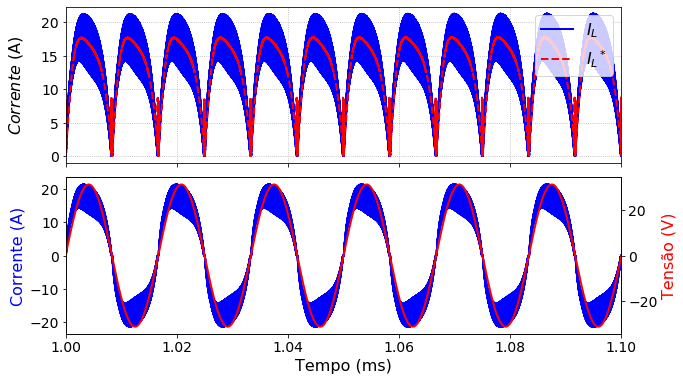

In [25]:
# Resultados de Corrente e tensão de entrada
fig, ax = plt.subplots(2,1, sharex='col')

# Plot um correntes
ax[0].plot(t,IL, label=r'$I_L$', linewidth=2, color='b')
ax[0].plot(t,Iref, label=r'${I_L}^*$', linewidth=2,  linestyle='--', color='r')
ax[0].legend(fontsize=16, loc='upper right')
ax[0].grid(which='both', linestyle=':')
ax[0].set_ylabel(r'$Corrente$ (A)', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)

# Plot tensão de entrada
axt = ax[1].twinx()
ax[1].plot(t, Ig, label=r'$I_g$', linewidth=2, color='b')
axt.plot(t, Vg, label=r'$V_g$', linewidth=2, color='r')
ax[1].set_xlabel(r'Tempo (ms)', fontsize=16)
ax[1].set_ylabel(r'Corrente (A)', fontsize=16, color='b')
axt.set_ylabel(r'Tensão (V)', fontsize=16, color='r')
ax[1].set_xlim(1,1.1)
ax[1].tick_params(axis='both', which='major', labelsize=14)
axt.tick_params(axis='both', which='major', labelsize=14)
# ax[1].legend(fontsize=16, loc='upper right')
fig.align_ylabels(ax)

# Configura e salva a figura
fig.set_size_inches(9.6, 5.4)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/PFC_entrada.pdf')
plt.show()

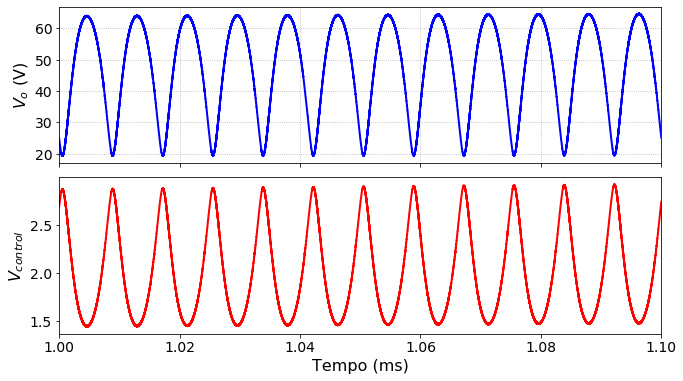

In [19]:
# Resultados de Corrente e tensão de entrada
fig, ax = plt.subplots(2,1, sharex='col')

# Plot um correntes
ax[0].plot(t,Vo, label=r'$I_L$', linewidth=2, color='b')
ax[0].grid(which='both', linestyle=':')
ax[0].set_ylabel(r'$V_o$ (V)', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)

# Plot tensão de entrada
ax[1].plot(t, Vcontrol, label=r'$V_g$', linewidth=2, color='r')
ax[1].set_xlabel(r'Tempo (ms)', fontsize=16)
ax[1].set_ylabel(r'$V_{control}$', fontsize=16)
ax[1].set_xlim(1,1.1)
ax[1].tick_params(axis='both', which='major', labelsize=14)

# Configura e salva a figura
fig.set_size_inches(9.6, 5.4)
plt.tight_layout()
plt.savefig('Relatorio/Imagens/Graficos/PFC_saida.pdf')
plt.show()